In [1]:
# Data manipulation and analysis
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve 

In [2]:
# Load and Prepare Data
df = pd.read_csv('../Customer Churn Dataset/customer_churn_dataset-training-master.csv')

# Check for missing values and data types
print(df.info())
print(df.isnull().sum())

# Handle missing values (if any)
df.fillna(method='ffill', inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440833 entries, 0 to 440832
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   CustomerID         440832 non-null  float64
 1   Age                440832 non-null  float64
 2   Gender             440832 non-null  object 
 3   Tenure             440832 non-null  float64
 4   Usage Frequency    440832 non-null  float64
 5   Support Calls      440832 non-null  float64
 6   Payment Delay      440832 non-null  float64
 7   Subscription Type  440832 non-null  object 
 8   Contract Length    440832 non-null  object 
 9   Total Spend        440832 non-null  float64
 10  Last Interaction   440832 non-null  float64
 11  Churn              440832 non-null  float64
dtypes: float64(9), object(3)
memory usage: 40.4+ MB
None
CustomerID           1
Age                  1
Gender               1
Tenure               1
Usage Frequency      1
Support Calls        1
Payment

C:\Users\Aftahi Islam\AppData\Local\Temp\ipykernel_38132\2203078092.py:9: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


In [3]:
# Convert categorical columns to numeric using LabelEncoder
categorical_cols = ['Gender', 'Subscription Type', 'Contract Length']
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le  # Save encoders for future use

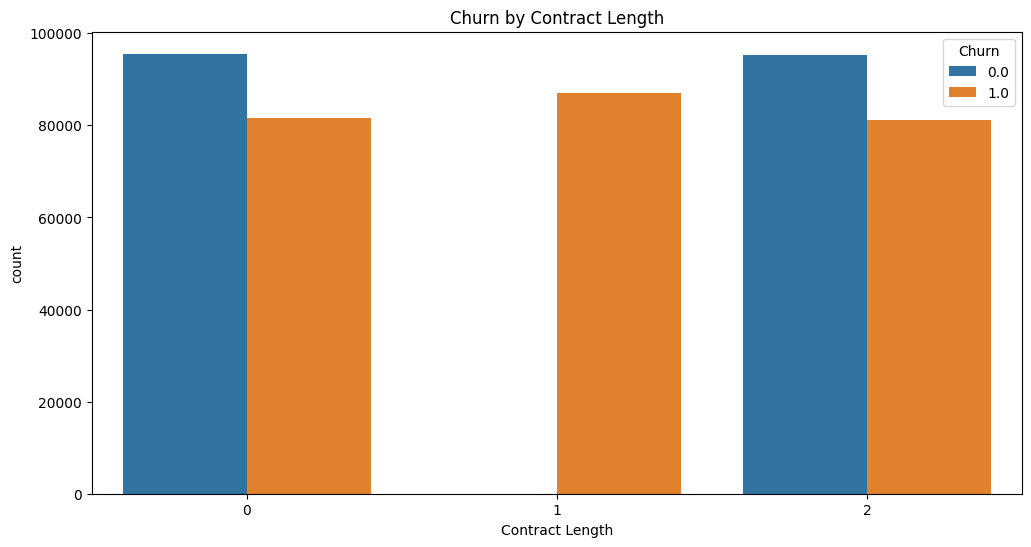

In [4]:
# Exploratory Data Analysis (EDA)
plt.figure(figsize=(12, 6))
sns.countplot(x='Contract Length', hue='Churn', data=df)
plt.title('Churn by Contract Length')
plt.show()

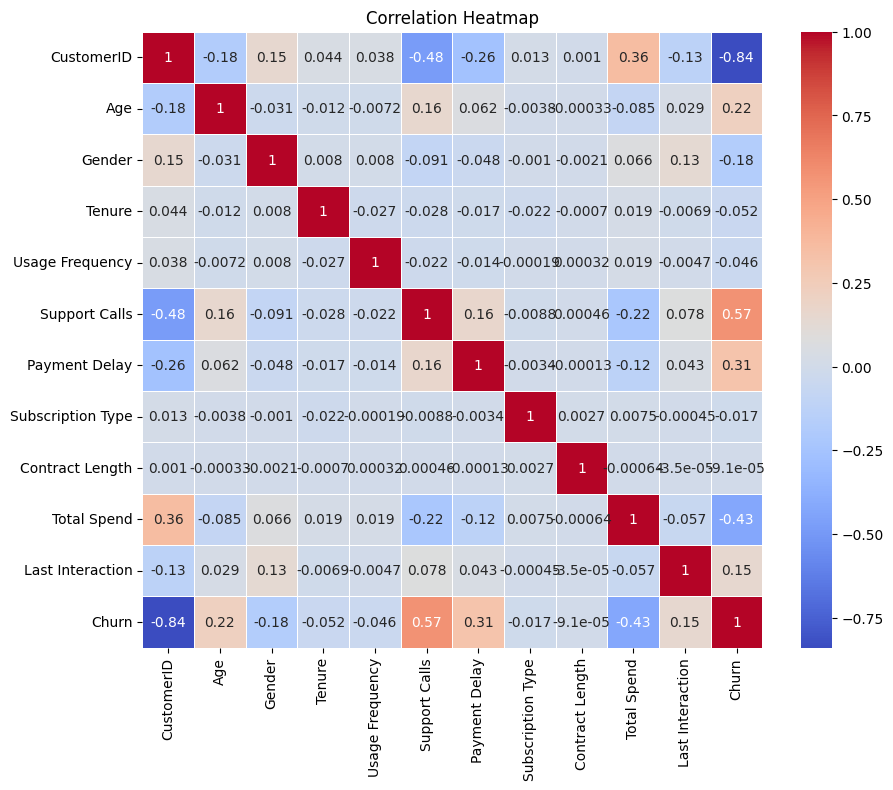

In [5]:
# Correlation heatmap to identify multicollinearity
corr = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

In [6]:
# Feature Engineering
df['tenure_group'] = pd.cut(df['Tenure'], bins=[0, 6, 12, 24, 36, np.inf], labels=['0-6', '6-12', '12-24', '24-36', '36+'])
df['monthly_usage'] = df['Total Spend'] / (df['Tenure'] + 1)  # Prevent division by zero

# Drop unnecessary columns (e.g., customer ID)
df = df.drop(['CustomerID'], axis=1)

In [7]:
# Split Data into Train and Test Sets
X = df.drop('Churn', axis=1)
y = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [8]:
# Inspect Categorical Columns
print(X_train.dtypes)

# Convert Categorical Columns by one-hot encoding or label encoding
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

# Ensuring Consistency between X_train and X_test
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

Age                   float64
Gender                  int64
Tenure                float64
Usage Frequency       float64
Support Calls         float64
Payment Delay         float64
Subscription Type       int64
Contract Length         int64
Total Spend           float64
Last Interaction      float64
tenure_group         category
monthly_usage         float64
dtype: object


In [9]:
# Feature Scaling 
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [10]:
# Model Building and Training
xgb_model = XGBClassifier(random_state=42, enable_categorical=True)

# Hyperparameter tuning using GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0]
}

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get the best parameters
print("Best Parameters:", grid_search.best_params_)

# Train the final model using best parameters
best_model = grid_search.best_estimator_

Best Parameters: {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 100, 'subsample': 1.0}


Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     57245
         1.0       1.00      1.00      1.00     75005

    accuracy                           1.00    132250
   macro avg       1.00      1.00      1.00    132250
weighted avg       1.00      1.00      1.00    132250

Confusion Matrix:
 [[57245     0]
 [   10 74995]]


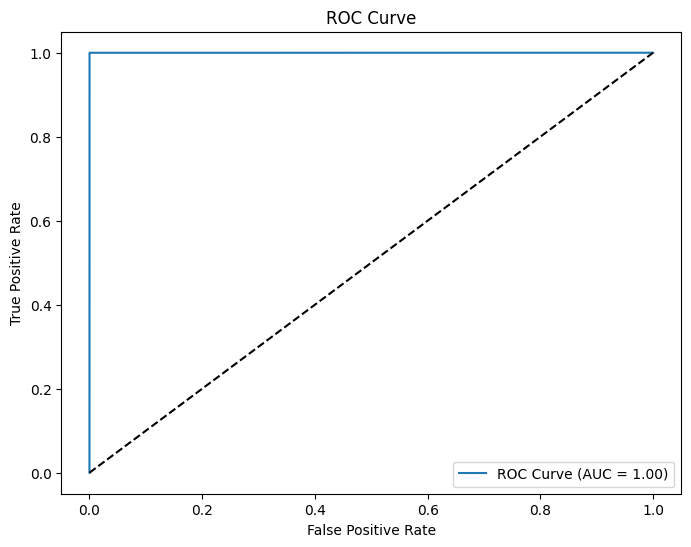

In [11]:
# Model Evaluation
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:, 1]  # For ROC-AUC

# Classification Report and Confusion Matrix
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# ROC-AUC Score and Plot
roc_auc = roc_auc_score(y_test, y_prob)
fpr, tpr, _ = roc_curve(y_test, y_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

In [12]:
# Cross-Validation for Model Reliability
cv_scores = cross_val_score(best_model, X, y, cv=5, scoring='roc_auc')
print(f'Average ROC-AUC Score from Cross-Validation: {np.mean(cv_scores):.2f}')

Average ROC-AUC Score from Cross-Validation: 1.00
